In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=16)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

In [2]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, get_xi_from_P, power_Kaiser

In [3]:
## Cosmological Parameters

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
# OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.00
cs2_DE  = 0.99
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Neff    = 2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
H0      = 67.742
A_s     = 2.1064e-09
n_s     = 0.96822

b       = 2.0   # bias
sigmaz  = 0.03  # redshift error


# list of parameters with respect to which we take derivatives
fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'Y_{He}', 'A_s', 'n_s', 'w_0', 'b_1', '\\sigma_z', 'w_a', 'c_s^2']
fiducial_cosmo_param = jnp.array([H0, Omegam, Omegab, Neff, mnu, Tcmb, YHe, A_s, n_s,  w_DE_0,  b, sigmaz, w_DE_a, cs2_DE])

# modes to sample
nmodes = 512
nmu    = 256
kmin   = 1e-4
kmax   = 1e+1
aexp   = 1.0 # scale factor at which to evaluate, can also be a jax.array



In [4]:
def Pkmu_of_cosmo( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    param = {}
    param['Omegam'] = args[1]
    param['Omegab'] = args[2]
    param['OmegaDE'] = 1-args[1]
    param['Omegak'] = 0.0
    param['A_s'] = args[7]
    param['n_s'] = args[8]
    param['H0'] = args[0]
    param['Tcmb'] = args[5]
    param['YHe'] = args[6]
    param['Neff'] = args[3]
    param['Nmnu'] = num_massive_neutrinos
    param['mnu'] = args[4]
    param['w_DE_0'] = args[9]
    param['w_DE_a'] = args[12]
    param['cs2_DE'] = args[13]

    param['k_p']  = 0.05

    b = args[10]
    sigmaz = args[11]

    ## Compute Background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')

    # Compute Perturbations
    # lmaxg  = 12
    # lmaxgp = 12
    # lmaxr  = 17
    # lmaxnu = 17
    # nqmax  = 15

    rtol   = 1e-4
    atol   = 1e-4

    aexp_out = jnp.atleast_1d(aexp)
    kmodes   = jnp.geomspace(kmin, kmax, nmodes)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out,
                                    #   lmaxg=lmaxg, lmaxgp=lmaxgp, lmaxr=lmaxr, lmaxnu=lmaxnu, nqmax=nqmax,
                                       rtol=rtol, atol=atol )

    Pkmu, mu, theta = power_Kaiser( y=y[:,-1,:], kmodes=kmodes, b=b, sigma_z = sigmaz, nmu=nmu, param=param )


    return Pkmu, mu, theta, kmodes


In [5]:
# compute the fiducial power spectrum
Pkmu, mu, theta, kmodes = Pkmu_of_cosmo( fiducial_cosmo_param )

In [6]:
# compute the derivative of the power spectrum with respect to the cosmological parameters, this takes some time... (ca. 2min, incl. compilation on RTX3090)
dPkmu_dcosmo = jax.jacfwd( Pkmu_of_cosmo )
dPkmu,_,_,_ = dPkmu_dcosmo( fiducial_cosmo_param )

Text(0, 0.5, '$\\log_{10} k$')

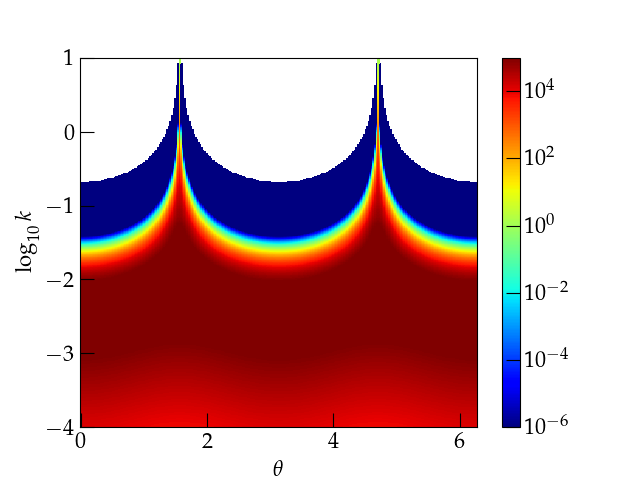

In [7]:

# create a map of the powerspectrum
fig, ax = plt.subplots()

im = ax.pcolor( theta, jnp.log10(kmodes), Pkmu, cmap='jet', shading='auto', norm=colors.LogNorm(vmin=1e-6, vmax=1e+5) )
plt.colorbar(im, ax=ax)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\log_{10} k$')

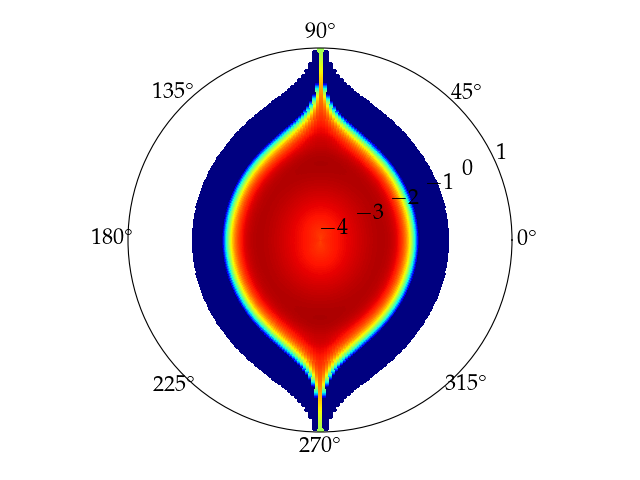

In [8]:
# create a polar map
fig, ax = plt.subplots()
ax.set_axis_off()
ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
ax.grid(False)
ax.pcolormesh( theta, jnp.log10(kmodes), Pkmu,edgecolors='face', norm=colors.LogNorm(vmin=1e-7, vmax=1e6),
                   cmap='jet', shading='auto')


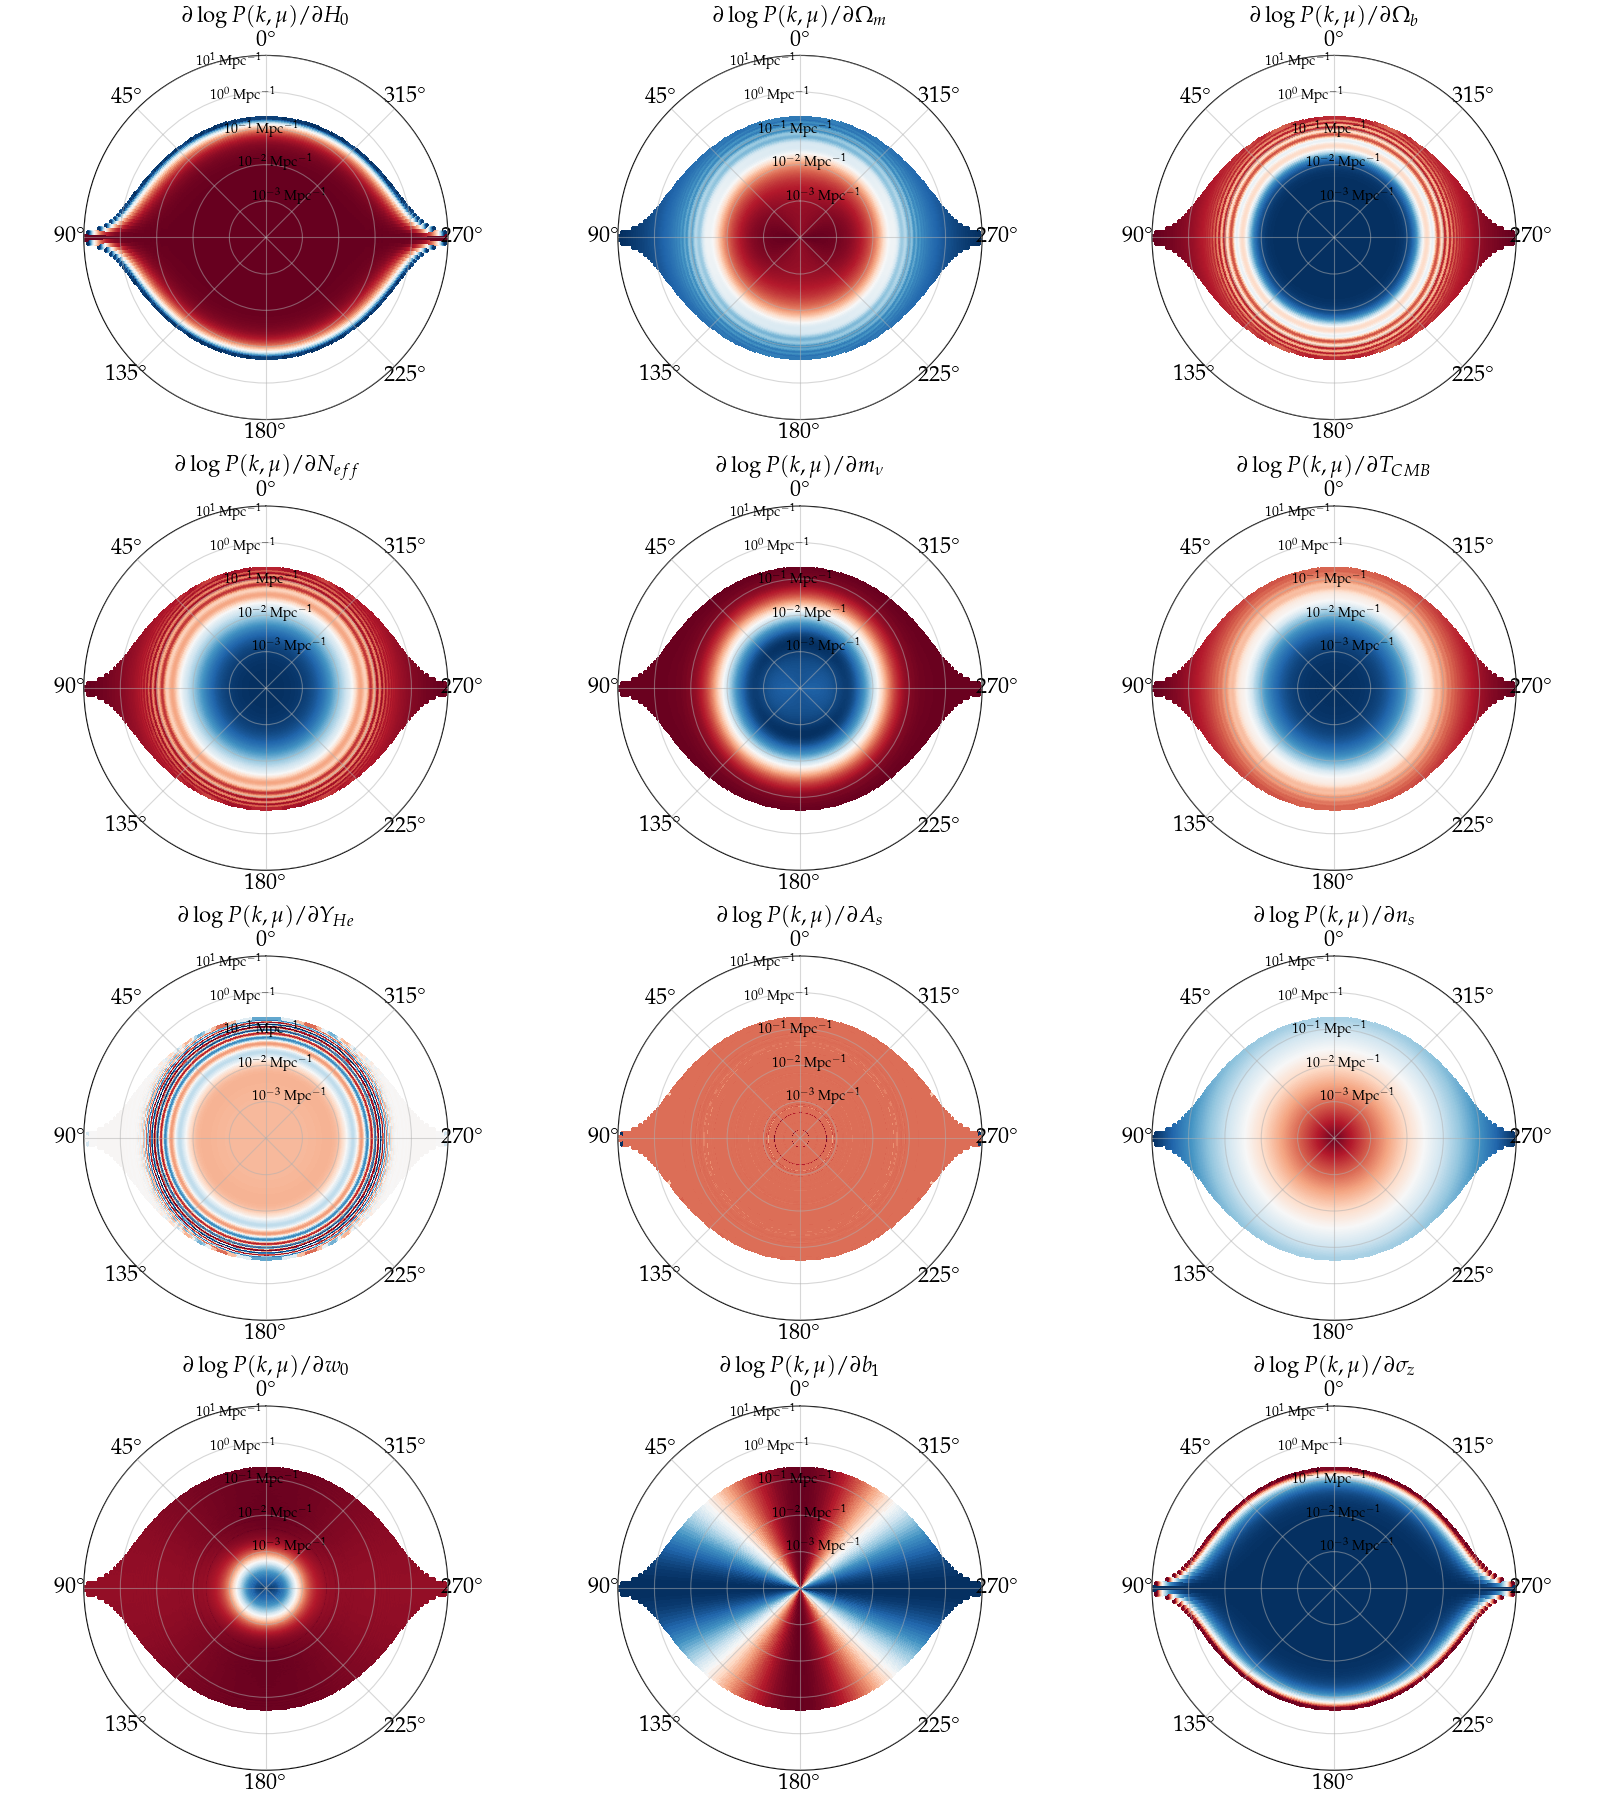

In [15]:

# create a polar map of the derivative of the power spectrum with respect to the cosmological parameters
# fig, ax = plt.subplots(layout='constrained')
fig,axs = plt.subplots(4,3,sharex=True,figsize=(16,18),layout='constrained',subplot_kw={'projection': 'polar'})

for i,ff in enumerate(fieldnames[:12]):
    iy = i%3
    ix = i//3
    dlogPkmu = dPkmu[...,i]/Pkmu

    ax = axs[ix,iy]
    ax.grid(False)
    ax.pcolormesh( theta, jnp.log10(kmodes), dPkmu[...,i]/Pkmu, edgecolors='face',
                      cmap='RdBu', shading='auto', rasterized=True)

    ax.set_theta_zero_location('N')
    ax.grid(True,alpha=0.5)
    ax.set_rticks([-3,-2,-1,0,1])
    ax.set_yticklabels(['$10^{-3}\\;{\\rm Mpc}^{-1}$','$10^{-2}\\;{\\rm Mpc}^{-1}$','$10^{-1}\\;{\\rm Mpc}^{-1}$','$10^{0}\\;{\\rm Mpc}^{-1}$','$10^{1}\\;{\\rm Mpc}^{-1}$'],size=10)
    ax.set_title(f'$\partial \log P(k,\mu)/\partial {fieldnames[i]}$')

plt.savefig('dlogPkmu_dcosmo.pdf',bbox_inches='tight', dpi=300)
# plt.savefig('dlogPkmu_dcosmo_dpi300.png',bbox_inches='tight', dpi=300)


In [10]:
#### To solve integral over mu, use jnp.trapz over mu dimension of Pkmu
ivar = 1
jvar = 2

Veff = jnp.ones((nmodes,nmu)) # effective volume, to implement
# product of derivatives
dPkmu_dcosmo_prod = dPkmu[...,ivar]*dPkmu[...,jvar] * Veff

# integrate over mu
dPk_dcosmo = jnp.trapz( dPkmu_dcosmo_prod, x=mu, axis=-1 )
# integrate over k
F_ij = 1/(8*jnp.pi**2) * jnp.trapz( dPk_dcosmo * kmodes**2, x=kmodes, axis=-1 )

print(F_ij)

-0.01545739521102485
